In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
import scipy.stats as stats
import tensorflow as tf

from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,GradientBoostingRegressor, 
HistGradientBoostingRegressor, VotingClassifier)
from sklearn.calibration import CalibratedClassifierCV

from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, optimizers, backend as K
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
mean_absolute_error, mean_squared_error, r2_score)
from xgboost import XGBClassifier

from category_encoders import TargetEncoder

from scipy.stats import loguniform, uniform
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



2025-05-28 14:10:38.385524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748441438.660180      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748441438.750692      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


/kaggle/input/global-ev-charging-behavior-2024/Global_EV_Charging_Behavior_2024.csv


In [2]:
!pip install scikit-learn --upgrade


## Section 1: Load dataset

Set to show all columns:

In [3]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000) 
pd.set_option('display.colheader_justify', 'center') 

In [4]:
df = pd.read_csv("/kaggle/input/global-ev-charging-behavior-2024/Global_EV_Charging_Behavior_2024.csv")
df.head()


,Country,City,Charging Station ID,Charging Station Type,EV Model,Manufacturer,Battery Capacity (kWh),Charging Start Time,Charging End Time,Charging Duration (mins),Energy Delivered (kWh),Charging Cost ($),Payment Method,Temperature (°C),Charging Session Outcome,Station Utilization Rate (%)
0,Germany,Berlin,CS-8195,DC Fast,Hyundai Kona Electric,Hyundai,64,2025-03-31 18:13:40,2025-03-31 19:30:40,77,18.17,5.83,Subscription,30.7,Completed,57.2
1,USA,New York,CS-5103,DC Fast,Nissan Leaf,Nissan,40,2025-03-08 13:17:05,2025-03-08 14:27:05,70,13.14,3.69,Card,23.6,Failed,53.6
2,France,Lyon,CS-4527,Level 1,BYD Han,BYD,76,2025-01-21 20:08:51,2025-01-21 21:34:51,86,62.47,6.37,Subscription,11.9,Aborted,22.4
3,India,Mumbai,CS-5717,DC Fast,Nissan Leaf,Nissan,40,2025-04-04 21:11:29,2025-04-04 23:03:29,112,8.39,2.97,App,27.3,Failed,46.8
4,Germany,Munich,CS-5093,Level 2,Nissan Leaf,Nissan,40,2025-03-27 14:58:49,2025-03-27 17:34:49,156,15.26,4.40,Subscription,2.7,Completed,13.7


## Section 2: Dataset description

In [5]:
df.columns

Index(['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)'], dtype='object')

### 2.1) Missing and duplicated values

In [6]:
summary = pd.DataFrame(index=df.columns)

# Missing items by column
summary["Missing_count"]   = df.isna().sum()
summary ['Missing_percent'] = (summary["Missing_count"] / len(df) * 100).round(2)
 
# Duplicated items by column
summary['Duplicated_count']   = df.apply(lambda s: s.duplicated().sum())
summary['Duplicated_percent'] = (summary["Duplicated_count"] / len(df) * 100).round(2)

dup_rows = df.duplicated().sum()
row_summary = pd.DataFrame({
    'Missing_count': np.nan,
    'Missing_percent': np.nan,
    'Duplicated_count'  : dup_rows,      # no aplica por fila
    'Duplicated_percent': (dup_rows / len(df) * 100).round(2)
}, index=['Duplicated rows'])

summary = pd.concat([summary]).sort_index();summary

,Missing_count,Missing_percent,Duplicated_count,Duplicated_percent
Battery Capacity (kWh),0,0.0,790,98.75
Charging Cost ($),0,0.0,160,20.00
Charging Duration (mins),0,0.0,635,79.38
Charging End Time,0,0.0,0,0.00
Charging Session Outcome,0,0.0,797,99.62
Charging Start Time,0,0.0,0,0.00
Charging Station ID,0,0.0,0,0.00
Charging Station Type,0,0.0,797,99.62
City,0,0.0,770,96.25
Country,0,0.0,790,98.75


In [7]:
df.duplicated().sum()

0

### 2.2) Numeric/Categorical summary

In [8]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       800 non-null    object 
 1   City                          800 non-null    object 
 2   Charging Station ID           800 non-null    object 
 3   Charging Station Type         800 non-null    object 
 4   EV Model                      800 non-null    object 
 5   Manufacturer                  800 non-null    object 
 6   Battery Capacity (kWh)        800 non-null    int64  
 7   Charging Start Time           800 non-null    object 
 8   Charging End Time             800 non-null    object 
 9   Charging Duration (mins)      800 non-null    int64  
 10  Energy Delivered (kWh)        800 non-null    float64
 11  Charging Cost ($)             800 non-null    float64
 12  Payment Method                800 non-null    obje

In [9]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(exclude="number").columns.tolist()

print("Numeric columns :", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns : ['Battery Capacity (kWh)', 'Charging Duration (mins)', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Temperature (°C)', 'Station Utilization Rate (%)']
Categorical columns: ['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Charging Start Time', 'Charging End Time', 'Payment Method', 'Charging Session Outcome']


In [10]:
df.describe().round(2)

,Battery Capacity (kWh),Charging Duration (mins),Energy Delivered (kWh),Charging Cost ($),Temperature (°C),Station Utilization Rate (%)
count,800.00,800.00,800.00,800.00,800.00,800.00
mean,66.26,99.02,35.93,9.16,14.46,51.46
std,18.15,48.84,20.42,6.33,11.47,22.99
min,40.00,15.00,5.01,0.59,-5.00,10.10
25%,52.00,54.00,19.38,4.23,4.40,31.48
50%,64.00,97.00,34.66,7.79,14.00,53.15
75%,77.00,142.00,50.04,12.65,24.10,70.82
max,95.00,180.00,93.60,36.45,35.00,89.80


### 2.3) EDA: Exploratory Data Analysis

#### Correlation Matrix

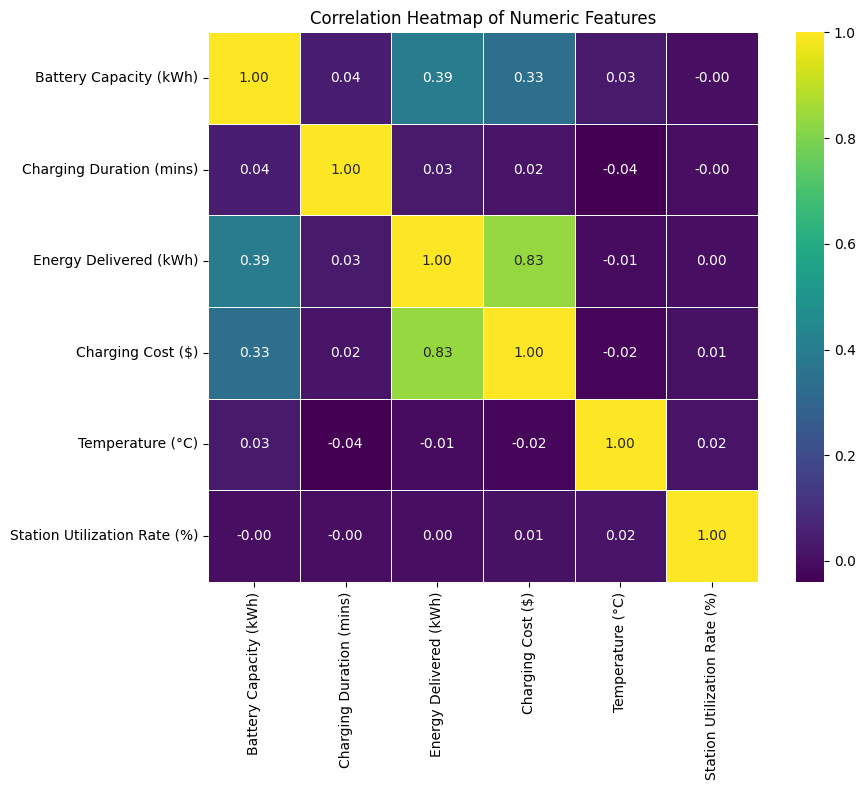

In [11]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            cmap='viridis',      
            annot=True, fmt=".2f",
            linewidths=0.5,
            square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.savefig("corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

We observe that 'Charging Cost' and 'Energy Delivered' are strongly related, showing a positive correlation coefficient of 0.83. In other words, the more energy delivered to the batteries, the higher the cost of the session.

Additionally, it is possible to infer those larger batteries ('Energy Capacity') tend to receive more energy per session. At the same time, we can detect an indirect correlation link via the energy delivered (more capacity involves more energy to charge and ultimately higher cost).

#### Charging Session Analysis¶

For the following analysis, we will begin by defining the colors for Charging Session Outcome and EV Models.

In [12]:
# Charging Session Outcome
custom_palette_outcome = {
    'Completed': '#1f9e89', 
    'Failed': '#f1605d',    
    'Aborted': '#3e4989'}

custom_palette_station = {
    'DC Fast': '#46327e', 
    'Level 1': '#4ac16d',    
    'Level 2': '#277f8e'}

# EV Models 
custom_palette_evmodel = {
    "Hyundai Kona Electric": "#FFE587",
    "Nissan Leaf": "#FFCF9F",
    "BYD Han": "#FFB3C1",
    "Audi e-tron": '#c994c7',#"#D2B2FF",
    "Kia EV6": "#CACDFF",
    "Porsche Taycan": '#a6bddb',#"#A8D9FF",
    "Renault Zoe": "#8EE9EA",
    "Tesla Model 3": '#addd8e',#"#B7F3A1",
    "BMW i3": "#E5F8B4",
    "Chevy Bolt": "#E6D2B5",
}

In [13]:
df['Charging Station Type'].unique()

array(['DC Fast', 'Level 1', 'Level 2'], dtype=object)

In [14]:
df['EV Model'].unique()

array(['Hyundai Kona Electric', 'Nissan Leaf', 'BYD Han', 'Audi e-tron',
       'Kia EV6', 'Porsche Taycan', 'Renault Zoe', 'Tesla Model 3',
       'BMW i3', 'Chevy Bolt'], dtype=object)

In [15]:
df['Country'].unique()

array(['Germany', 'USA', 'France', 'India', 'Japan', 'Australia',
       'Norway', 'Canada', 'UK', 'China'], dtype=object)

It is important to note that the analysis focuses on 10 electric vehicle models; the following graph shows the number of charging sessions per country through 2024 by EV model.

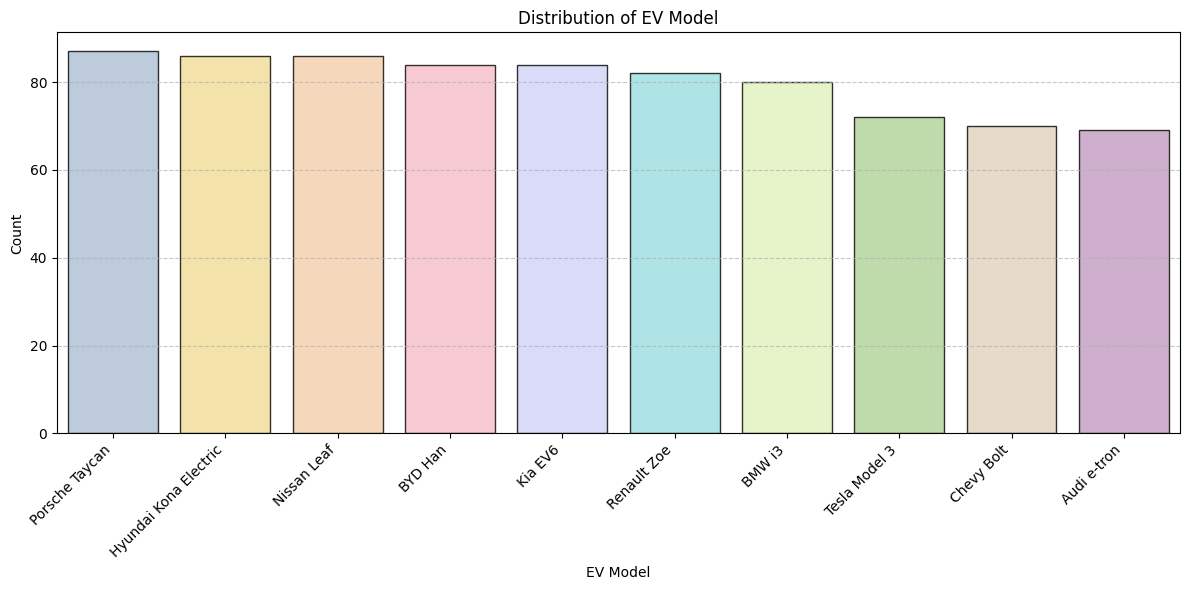

In [16]:
top10 = (df['EV Model'].value_counts().head(10).rename_axis('EV Model').reset_index(name='Sessions'))

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10,
    x='EV Model',
    y='Sessions',
    palette=custom_palette_evmodel,
    edgecolor='black',
    alpha=0.8)

plt.title('Distribution of EV Model')   # cambia el título si conviene
plt.xlabel('EV Model')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Distribution_EVModel.png", dpi=300, bbox_inches="tight")
plt.show()

From Figure, it is evident that the 10 models present in the dataset are frequently loaded in the different 10 countries.

#### Relation between model and manufacturer

In [17]:
mapping_df = (df[["Manufacturer", "EV Model"]].drop_duplicates().sort_values(["Manufacturer", "EV Model"]))
manu_to_models = (mapping_df.groupby("Manufacturer")["EV Model"].apply(list).to_dict())
print(manu_to_models)

{'Audi': ['Audi e-tron'], 'BMW': ['BMW i3'], 'BYD': ['BYD Han'], 'Chevrolet': ['Chevy Bolt'], 'Hyundai': ['Hyundai Kona Electric'], 'Kia': ['Kia EV6'], 'Nissan': ['Nissan Leaf'], 'Porsche': ['Porsche Taycan'], 'Renault': ['Renault Zoe'], 'Tesla': ['Tesla Model 3']}


#### Charging sessions by country

The following image separates the number of loads by country and model.

In [18]:
counts = (df.groupby(["Country", "EV Model"]).size().unstack(fill_value=0).reindex(columns=custom_palette_evmodel.keys(), fill_value=0))
counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

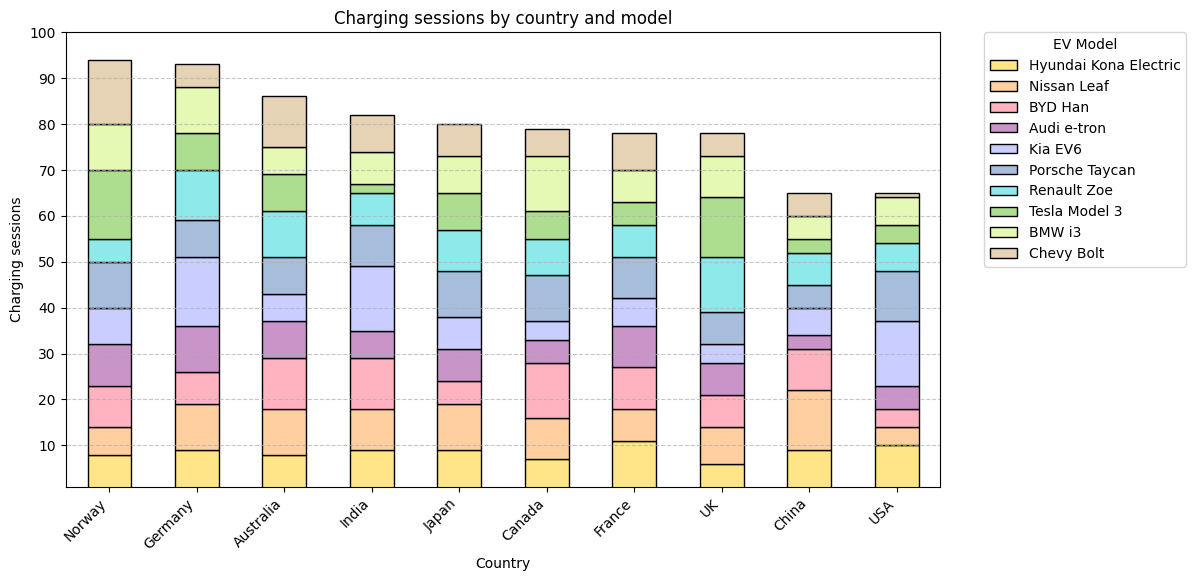

In [19]:
ax = counts.plot(kind="bar",
                 stacked=True,
                 figsize=(12, 6),
                 color=[custom_palette_evmodel[m] for m in counts.columns], edgecolor='black')

ax.set_xlabel("Country")
ax.set_ylabel("Charging sessions")
ax.set_title("Charging sessions by country and model")
plt.legend(title="EV Model",
           bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.yticks(np.arange(0, 101, 10))
plt.ylim(1,100)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Charging sessions by country and model.png", dpi=300, bbox_inches="tight")
plt.show()

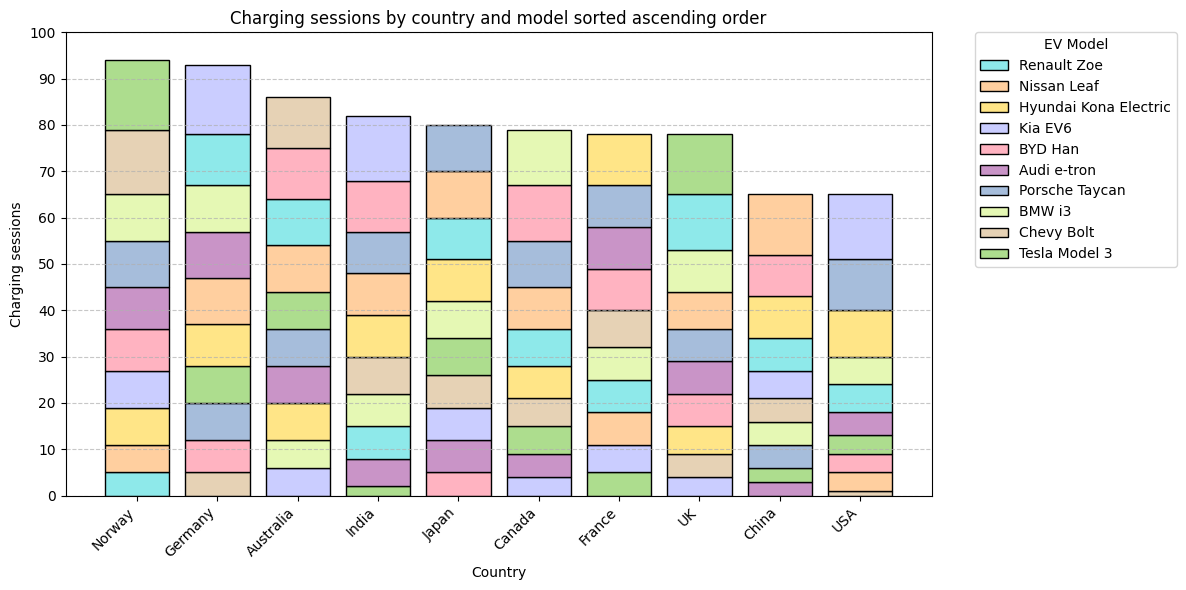

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

for idx, (country, row) in enumerate(counts.iterrows()):
    bottom = 0
    for model, value in row.sort_values().items():          
        if value == 0:
            continue
        ax.bar(
            idx, value, bottom=bottom,
            color=custom_palette_evmodel[model],edgecolor='black',
            label=model if idx == 0 else None)
        bottom += value

ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, rotation=45, ha="right")
ax.set_xlabel("Country")
ax.set_ylabel("Charging sessions")
ax.set_title("Charging sessions by country and model sorted ascending order")

ax.set_ylim(1, 100)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis="y", linestyle="--", alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="EV Model",
          bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()

While all models have some degree of presence in the 10 countries, the visualization confirms that the file contains a balanced distribution of sessions by model and country.

Tesla shows notable dominance in Norway and the United Kingdom, with good representation globally except for India and China, where charging sessions are limited.

Kia appears as the leading manufacturer in Germany, India, and the United States. Nissan dominates the Asian market, both in Japan and China, as does BYD in Australia, India, China, and Canada.

#### Number of sessions per country according to type of charging stations

In [21]:
grouped = (df.groupby(["Country", "Charging Station Type"]).size().reset_index(name="Sessions"))
grouped = grouped.sort_values(by="Sessions", ascending=False).reset_index(drop=True)


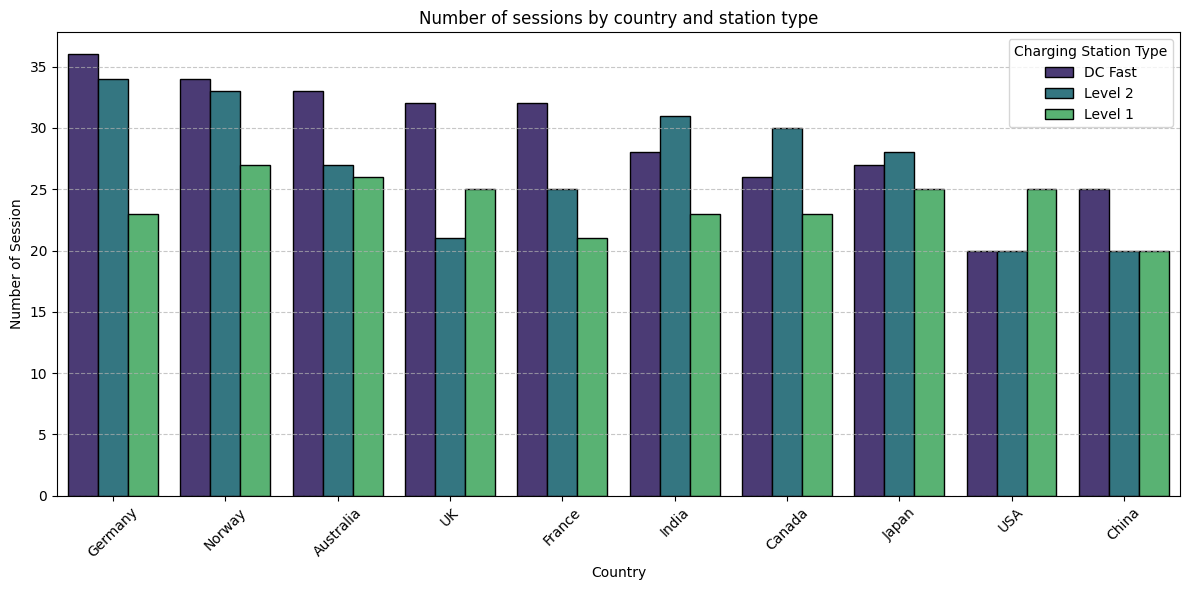

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="Country", y="Sessions", hue="Charging Station Type", palette=custom_palette_station,edgecolor='black',
    order=grouped["Country"].value_counts().index)

plt.title("Number of sessions by country and station type")
plt.xlabel("Country")
plt.ylabel("Number of Session")
plt.legend(title="Charging Station Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Number of sessions by country and station type.png", dpi=300, bbox_inches="tight")
plt.show()

To illustrate user preferences regarding different electric vehicle (EV) charging types and speeds, we define the following charging levels according to the U.S. Department of Transportation (2025):

* **Level 1:**

  * Uses a standard residential 120V AC outlet.
  * Slowest charging method; takes approximately **40-50+ hours** to charge Battery Electric Vehicles (BEVs) to 80%.

* **Level 2:**

  * Uses higher-voltage 240V outlets, commonly found in homes, workplaces, and public charging stations.
  * Faster than Level 1; charges BEVs to 80% within **4-10 hours**.

* **DC Fast Charging (DCFC):**

  * Employs direct current (DC) for rapid charging, typically available at commercial charging stations along high-traffic routes.
  * Fastest option; charges BEVs to 80% within **20 min

According to the figure, the widespread use of DC Fast indicates that users strongly want faster charging options in most countries.Level 2 stations are also frequently preferred over Level 1 stations, so it is important to analyse the times at which these preferences occur and whether they are successful or not.edominantly occur.
es predominantly occur.

#### Number of sessions per country according to the result of the loading session

In [23]:
grouped_outcome = (df.groupby(["Country", "Charging Session Outcome"]).size().reset_index(name="Result outcome sessions"))

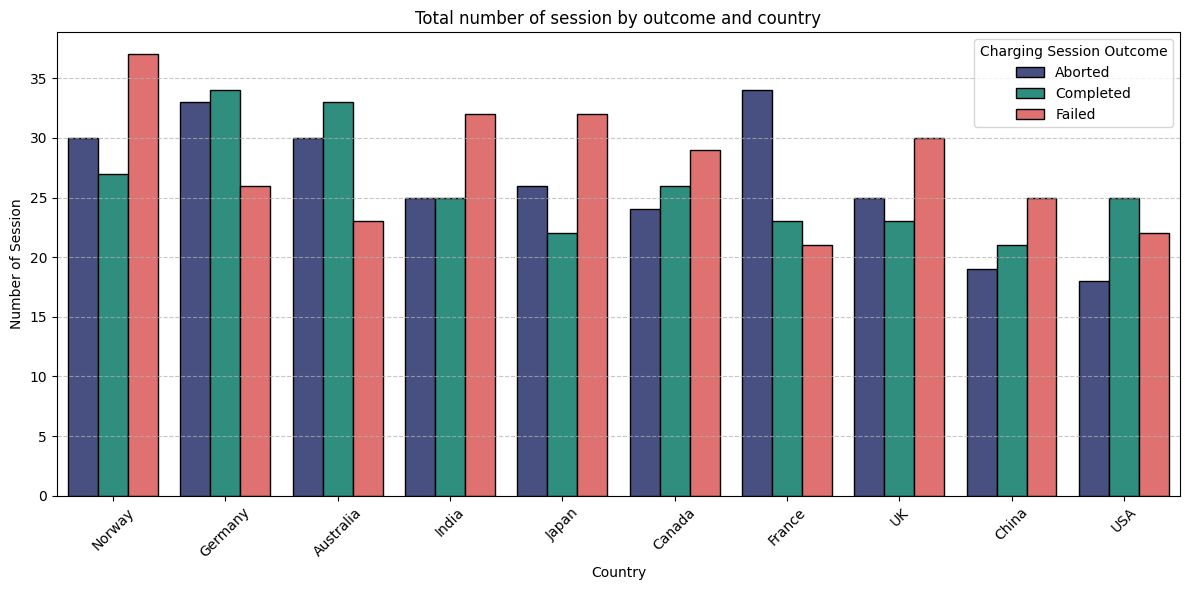

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_outcome, x="Country", y="Result outcome sessions", hue="Charging Session Outcome", edgecolor='black',palette=custom_palette_outcome,
    order=grouped_outcome.groupby("Country")["Result outcome sessions"].sum().sort_values(ascending=False).index)

plt.title("Total number of session by outcome and country")
plt.xlabel("Country")
plt.ylabel("Number of Session")
plt.legend(title="Charging Session Outcome")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Number of sessions per EV model according to the result of the loading session

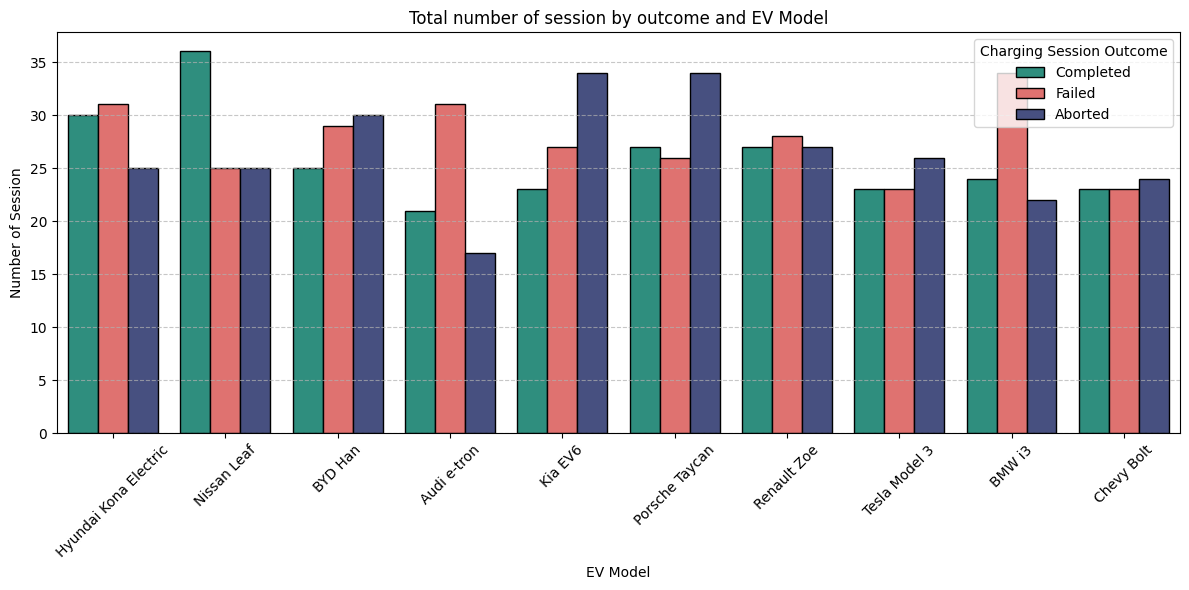

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='EV Model', hue='Charging Session Outcome', palette=custom_palette_outcome, edgecolor='black')

plt.title("Total number of session by outcome and EV Model")
plt.xlabel("EV Model")
plt.ylabel("Number of Session")
plt.xticks(rotation=45)
plt.legend(title='Charging Session Outcome')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Number of sessions per EV model according to the result of the loading session.png", dpi=300, bbox_inches="tight")
plt.show()

The Nissan Leaf leads the way in successful charging, while the Audi e-tron and BMW i3 show a high failure rate. The Renault Zoe and Chevy Bolt have balanced rates across all three types of outcomes, indicating a mixed experience using the charging infrastructure.

#### Battery Capacity Analysis

Now, we proceed to study the mean battery capacity (kWh) according to EV model:

In [26]:
capacity_df = (df.groupby('EV Model')['Battery Capacity (kWh)'].mean().reset_index().sort_values('Battery Capacity (kWh)', ascending=False))

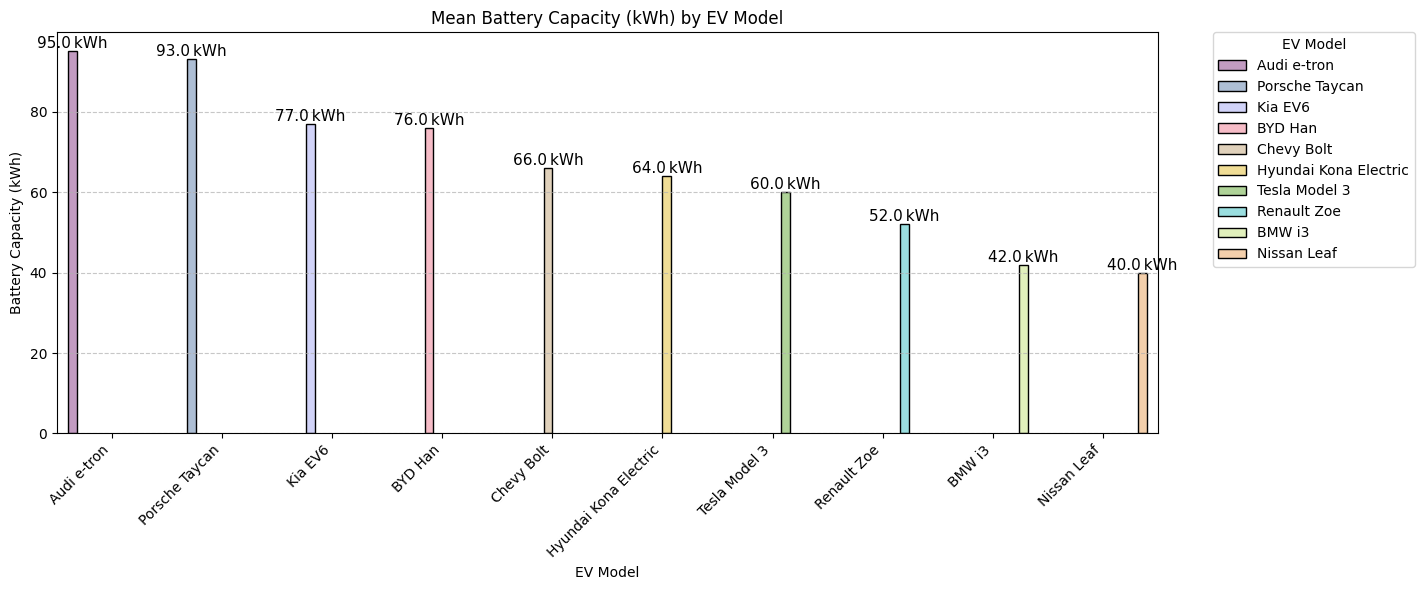

In [27]:
plt.figure(figsize=(12, 6))
ax= sns.barplot(data=capacity_df, x='EV Model', y='Battery Capacity (kWh)',hue='EV Model', edgecolor='black', palette=custom_palette_evmodel)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f kWh', fontsize=11, label_type='edge') 

plt.title('Mean Battery Capacity (kWh) by EV Model')
plt.xlabel('EV Model')
plt.ylabel('Battery Capacity (kWh)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Mean Battery Capacity (kWh) by EV Model.png", dpi=300, bbox_inches="tight")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="EV Model",
          bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.show()

#### Average EV charging time and cost

In [28]:
df2=df.copy()

In [29]:
charging_time_df2 = (df2.groupby(['EV Model', 'Charging Station Type'], as_index=False)['Charging Duration (mins)'].mean()
    .rename(columns={'Charging Duration (mins)': 'Average Charging Duration (mins)'})
    .sort_values('Average Charging Duration (mins)', ascending=False)
    .reset_index(drop=True))

print(charging_time_df2)

          EV Model        Charging Station Type  Average Charging Duration (mins)
0          Porsche Taycan         Level 1                   121.814815           
1           Tesla Model 3         DC Fast                   112.111111           
2                 BYD Han         DC Fast                   111.137931           
3                 Kia EV6         Level 1                   108.320000           
4          Porsche Taycan         DC Fast                   107.545455           
5           Tesla Model 3         Level 2                   107.480000           
6             Renault Zoe         Level 1                   106.809524           
7   Hyundai Kona Electric         DC Fast                   106.464286           
8                  BMW i3         DC Fast                   105.633333           
9             Nissan Leaf         Level 1                   105.464286           
10                Kia EV6         DC Fast                   102.612903           
11              

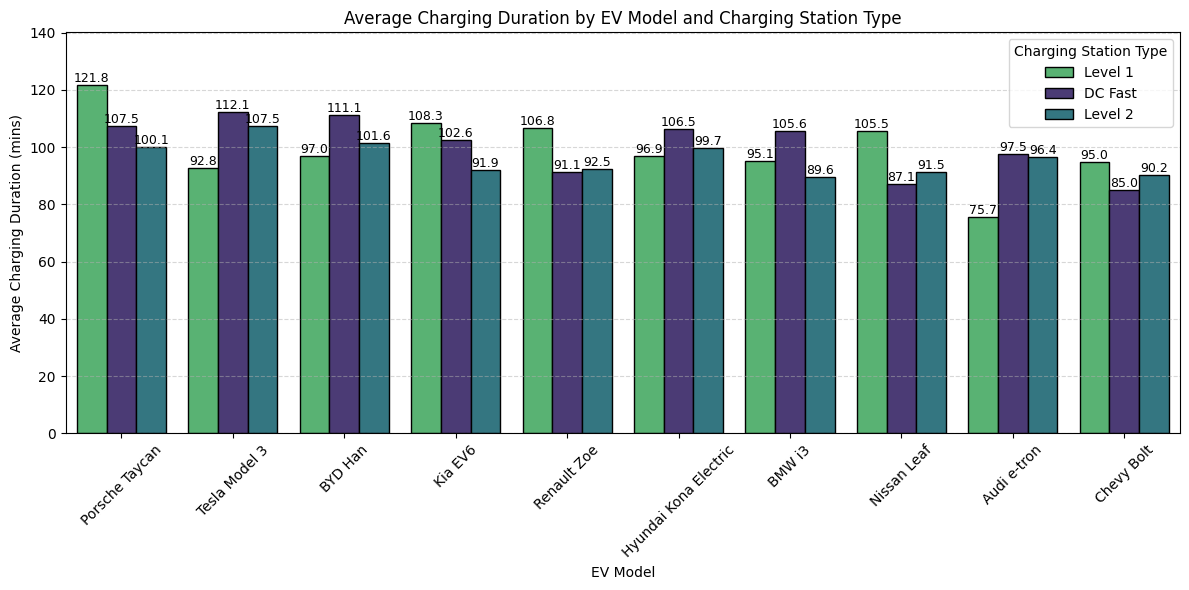

In [30]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=charging_time_df2, x='EV Model', y='Average Charging Duration (mins)', hue='Charging Station Type', edgecolor='black', palette=custom_palette_station)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f', fontsize=9, label_type='edge')

ax.set_ylabel('Average Charging Duration (mins)')
ax1.set_xlabel('EV Model')
ax1.set_title('Average Charging Duration by EV Model and Charging Station Type')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, charging_time_df2['Average Charging Duration (mins)'].max() * 1.15)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

ax1.legend(title='Charging Station Type')

plt.tight_layout()
plt.savefig("Average Charging Duration by EV Model and Charging Station Type.png", dpi=300, bbox_inches='tight')
plt.show()

Charging times differ significantly among electric vehicle variants.  For most models, the range is quite large; depending on the type of station, charging times can vary even among the same model.

In [31]:
df2['Average Charging Speed']=(df2['Energy Delivered (kWh)']/df2['Charging Duration (mins)'])*60 

charging_speed_df2 = (df2.groupby(['EV Model', 'Charging Station Type'], as_index=False)['Average Charging Speed'].mean()
    .sort_values('Average Charging Speed', ascending=False).reset_index(drop=True))

print(charging_speed_df2)

          EV Model        Charging Station Type  Average Charging Speed
0             Audi e-tron         Level 1               63.351904      
1                 BYD Han         Level 1               44.015483      
2             Audi e-tron         Level 2               41.978748      
3             Audi e-tron         DC Fast               41.579962      
4              Chevy Bolt         Level 1               39.173835      
5                 Kia EV6         Level 1               39.087907      
6              Chevy Bolt         Level 2               39.078679      
7                 Kia EV6         Level 2               38.695311      
8              Chevy Bolt         DC Fast               38.122702      
9          Porsche Taycan         DC Fast               36.681204      
10                Kia EV6         DC Fast               35.993007      
11            Renault Zoe         DC Fast               34.796789      
12         Porsche Taycan         Level 2               34.63834

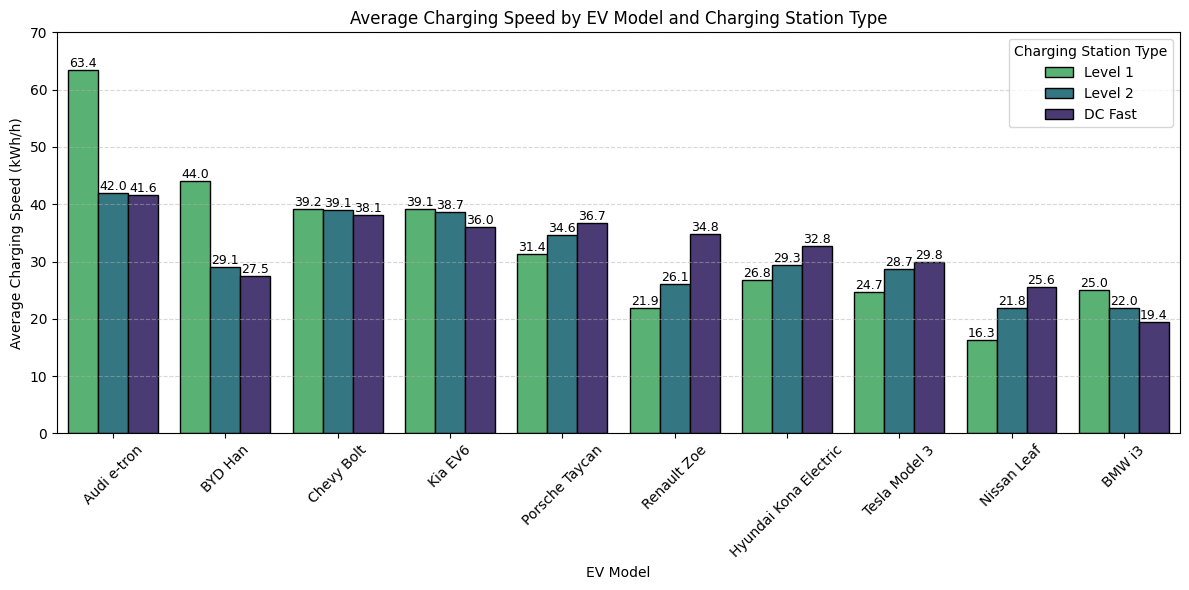

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=charging_speed_df2, x='EV Model', y='Average Charging Speed', hue='Charging Station Type', edgecolor='black', palette=custom_palette_station)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f', fontsize=9, label_type='edge')

ax1.set_ylabel('Average Charging Speed (kWh/h)')
ax1.set_xlabel('EV Model')
ax1.set_title('Average Charging Speed by EV Model and Charging Station Type')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(1, 70)
ax1.set_yticks(np.arange(0, 71, 10))

ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.legend(title='Charging Station Type')
plt.tight_layout()
plt.savefig("Average Charging Speed by EV Model and Charging Station Type.png", dpi=300, bbox_inches='tight')
plt.show()

The assertion that DC fast chargers often have faster charging speeds than Level 2 stations is generally supported by the majority of models. However, save for Audi and BYD vehicles, Level 1 stations have the lowest average speeds.

In [33]:
charging_cost_df = (df2.groupby(['EV Model', 'Charging Station Type'], as_index=False)['Charging Cost ($)']
       .mean().sort_values('Charging Cost ($)', ascending=False).reset_index(drop=True))

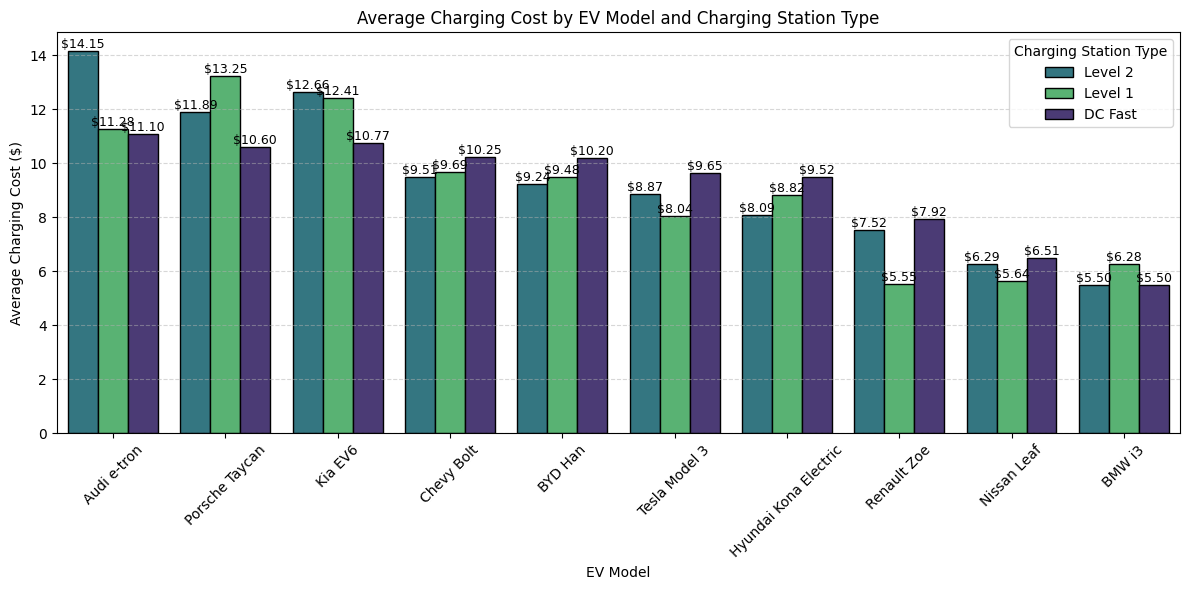

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=charging_cost_df, x='EV Model', y='Charging Cost ($)', hue='Charging Station Type', edgecolor='black', palette=custom_palette_station)

for container in ax.containers:
    ax.bar_label(container, fmt='$%.2f', fontsize=9, label_type='edge')

ax.set_ylabel('Average Charging Cost ($)')
ax.set_xlabel('EV Model')
ax.set_title('Average Charging Cost by EV Model and Charging Station Type')
ax.tick_params(axis='x', rotation=45)

ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(title='Charging Station Type', loc='upper right')
plt.tight_layout()
plt.savefig("Average Charging Cost by EV Model and Charging Station Type.png", dpi=300, bbox_inches='tight')
plt.show()

In terms of energy costs, the graph demonstrates that Audi, Porsche, and Kia have the highest charging costs, which makes sense given their battery capacities, as shown in Figure 'Mean Battery Capacity (kWh) by EV Model'. At the same time, the lowest charging costs are for BMW and Nissan models.

#### Charging Profile by Month and Station Type

In [35]:
df2['Session_Start'] = pd.to_datetime(df2['Charging Start Time'], errors='coerce')
df2['Month'] = df2['Session_Start'].dt.month_name()
df2['Hour'] = df2['Session_Start'].dt.hour

In [36]:
# Group average energy delivered by hour, month and station type
hourly_profile = (df2.groupby(['Month', 'Hour', 'Charging Station Type'])['Energy Delivered (kWh)'].mean().reset_index())

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future ver

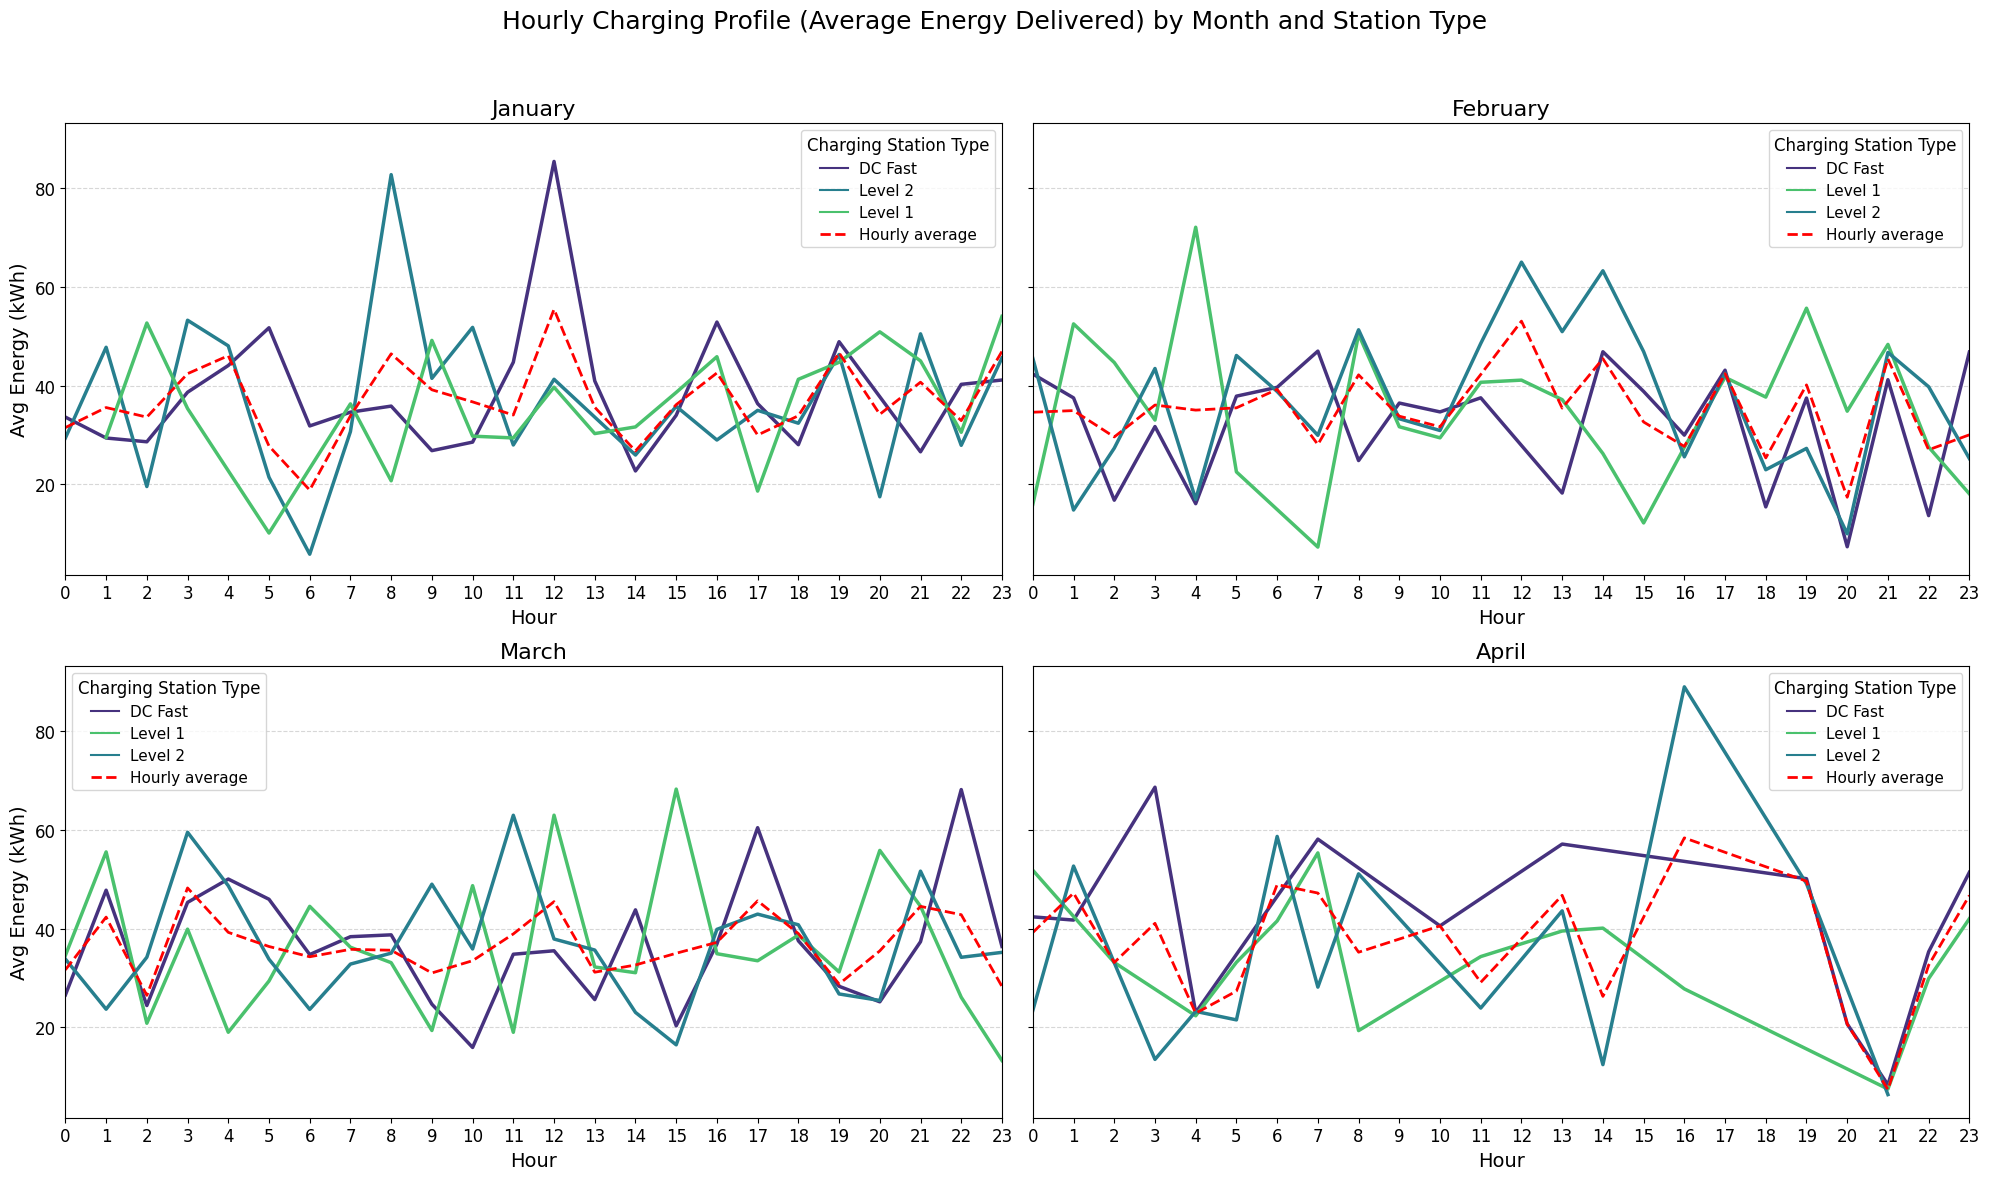

In [37]:
month_order = ['January', 'February', 'March', 'April']
hourly_profile['Month'] = pd.Categorical(hourly_profile['Month'], categories=month_order, ordered=True)

fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

axes = axes.flatten()
for i, month in enumerate(month_order):
    ax = axes[i]
    data = hourly_profile[hourly_profile['Month'] == month]
    avg_data = (data.groupby('Hour')['Energy Delivered (kWh)'].mean().reset_index())
    
    sns.lineplot(data=data, x='Hour', y='Energy Delivered (kWh)', hue='Charging Station Type', palette=custom_palette_station, linewidth=2.5, ax=ax)
    
    sns.lineplot(data=avg_data, x='Hour',y='Energy Delivered (kWh)',
        color='red', linestyle='--', linewidth=2, label='Hourly average', ax=ax)

    ax.set_title(month, fontsize=16)
    ax.set_xticks(range(0, 24, 1))
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour', fontsize=14)
    ax.set_ylabel('Avg Energy (kWh)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Hourly Charging Profile (Average Energy Delivered) by Month and Station Type', fontsize=18)

for ax in axes:
    legend = ax.get_legend()
    if legend:
        legend.set_title("Charging Station Type", prop={'size': 12})
        for text in legend.get_texts():
            text.set_fontsize(11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Hourly Charging Profile with Monthly Average.png", dpi=300, bbox_inches='tight')
plt.show()

In general, the highest consumption peaks occur between 7 a.m. and noon in January. In February, peak consumption occurs between noon and 3 p.m. March has a "flat" charging pattern during the day but tends to have small peaks between 10 a.m. and noon. April, a warm month, has a clear tendency toward charging during the afternoon, from 4 p.m. to 8 p.m.

### 2.4) Outlier and boxplot

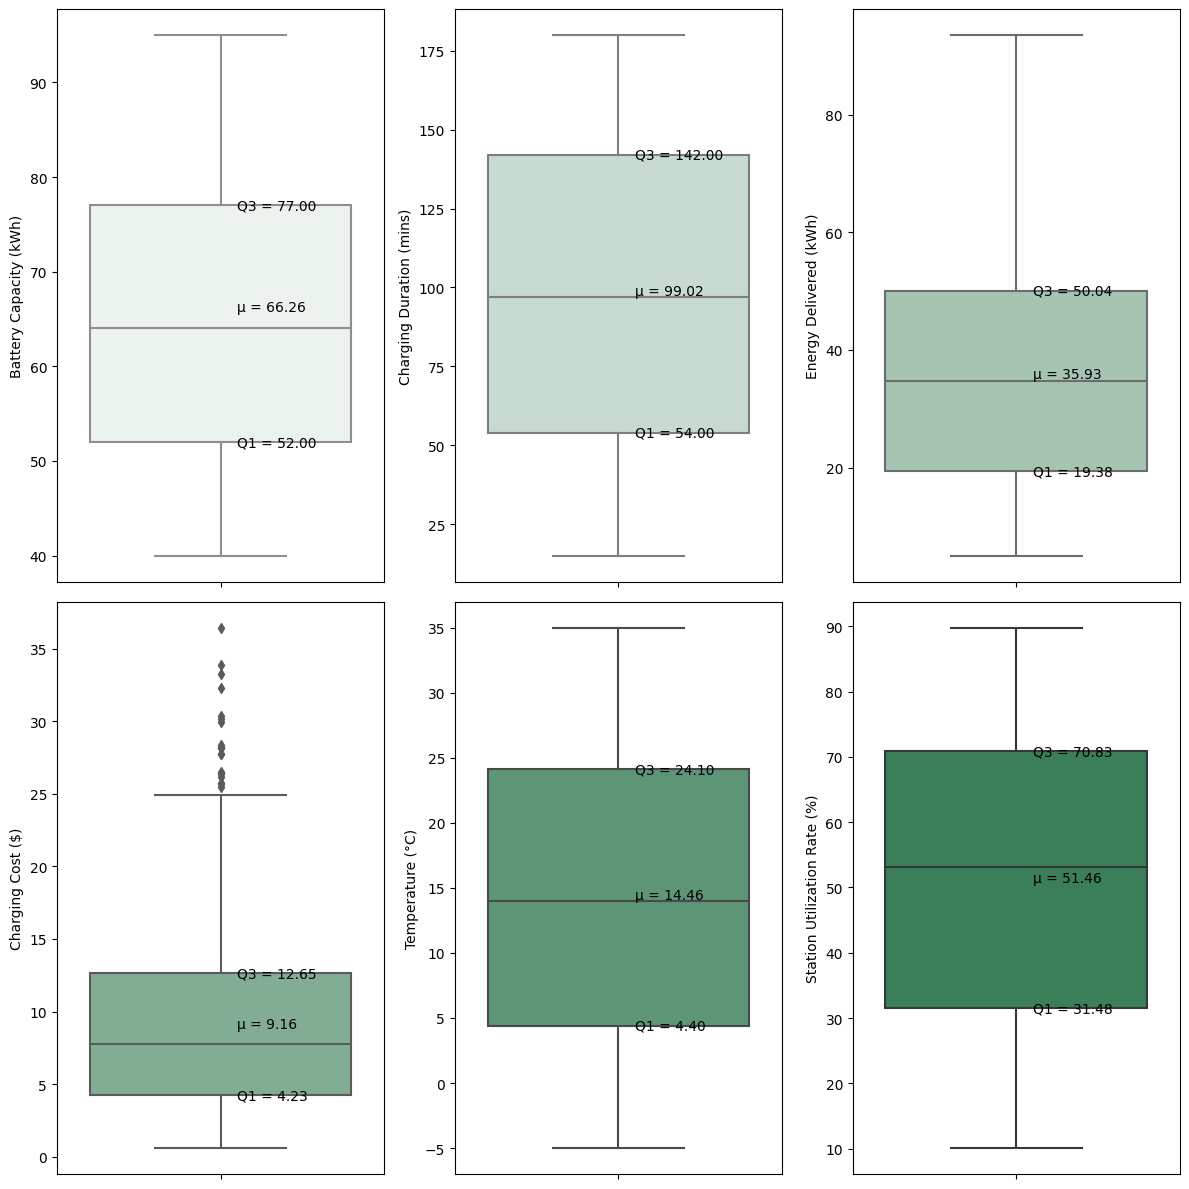

In [38]:
colors = sns.light_palette("seagreen", len(numeric_cols))

fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_cols):
    sns.boxplot(y=df[feature], ax=axes[i], color=colors[i])
    Serie = df[feature].dropna()
    av = Serie.mean()
    q1    = Serie.quantile(0.25)
    q3    = Serie.quantile(0.75)

    x_text = 0.05
    for y_val, label in [(av, f"μ = {av:.2f}"),
                         (q3,    f"Q3 = {q3:.2f}"),
                         (q1,    f"Q1 = {q1:.2f}")]:
        axes[i].text(
            x_text, y_val, label,
            ha='left', va='center',
            fontsize=10, color='black')
plt.tight_layout()
plt.savefig("Numeric_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

In [39]:
axes = axes.flatten()
outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_counts[col] = ((df[col] < lower) | (df[col] > upper)).sum()

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count'])
outlier_df['outlier_percent'] = (outlier_df['outlier_count'] / len(df) * 100).round(2)
outlier_df.sort_values('outlier_percent', ascending=False)

,outlier_count,outlier_percent
Charging Cost ($),20,2.5
Battery Capacity (kWh),0,0.0
Charging Duration (mins),0,0.0
Energy Delivered (kWh),0,0.0
Temperature (°C),0,0.0
Station Utilization Rate (%),0,0.0


Considering that these data correspond to a smaller fraction of the total, it was decided not to eliminate them in order to study the nature of these high costs.


In [40]:
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

### 2.5) Correlation Matrix and Encode target classes

In [41]:
df.columns = (
    df.columns
      .str.strip()                        
      .str.lower()                        
      .str.replace(r"[ \(\)\/%°\$]", "_", regex=True)  
      .str.replace(r"__+", "_", regex=True) 
      .str.strip("_"))

text_cols = df.select_dtypes(include=['object']).columns
for col in df.select_dtypes(include='object').columns:
    df[col] = (
        df[col]
          .astype(str)                    
          .str.strip()                    
          .str.lower()                    
          .str.replace(r"\s+", "", regex=True))
print(df[text_cols].head())


  country    city   charging_station_id charging_station_type       ev_model       manufacturer payment_method charging_session_outcome
0  germany   berlin        cs-8195              dcfast         hyundaikonaelectric    hyundai    subscription          completed       
1      usa  newyork        cs-5103              dcfast                  nissanleaf     nissan            card             failed       
2   france     lyon        cs-4527              level1                      bydhan        byd    subscription            aborted       
3    india   mumbai        cs-5717              dcfast                  nissanleaf     nissan             app             failed       
4  germany   munich        cs-5093              level2                  nissanleaf     nissan    subscription          completed       


In [42]:
data=df
data['start_hour'] = data['charging_start_time'].dt.hour
data['end_hour'] = data['charging_end_time'].dt.hour
data['start_weekday'] = data['charging_start_time'].dt.weekday + 1  # Monday=1, Sunday=7
data['month'] = data['charging_start_time'].dt.month

#Target variable
le = LabelEncoder()
data["outcome"] = le.fit_transform(data['charging_session_outcome'].astype(str))
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Encoded of Target variable:", mapping)

df = df.rename(columns={
    'charging_duration_mins':   'duration',
    'station_utilization_rate': 'Utilization',
    'temperature_c':            'temperature',
    'battery_capacity_kwh':     'capacity',
    'charging_cost':             'cost',
    'energy_delivered_kwh':    'energy_delivered',
})

Mapping Encoded of Target variable: {'aborted': 0, 'completed': 1, 'failed': 2}


In [43]:
data.head()

,country,city,charging_station_id,charging_station_type,ev_model,manufacturer,battery_capacity_kwh,charging_start_time,charging_end_time,charging_duration_mins,energy_delivered_kwh,charging_cost,payment_method,temperature_c,charging_session_outcome,station_utilization_rate,start_hour,end_hour,start_weekday,month,outcome
0,germany,berlin,cs-8195,dcfast,hyundaikonaelectric,hyundai,64,2025-03-31 18:13:40,2025-03-31 19:30:40,77,18.17,5.83,subscription,30.7,completed,57.2,18,19,1,3,1
1,usa,newyork,cs-5103,dcfast,nissanleaf,nissan,40,2025-03-08 13:17:05,2025-03-08 14:27:05,70,13.14,3.69,card,23.6,failed,53.6,13,14,6,3,2
2,france,lyon,cs-4527,level1,bydhan,byd,76,2025-01-21 20:08:51,2025-01-21 21:34:51,86,62.47,6.37,subscription,11.9,aborted,22.4,20,21,2,1,0
3,india,mumbai,cs-5717,dcfast,nissanleaf,nissan,40,2025-04-04 21:11:29,2025-04-04 23:03:29,112,8.39,2.97,app,27.3,failed,46.8,21,23,5,4,2
4,germany,munich,cs-5093,level2,nissanleaf,nissan,40,2025-03-27 14:58:49,2025-03-27 17:34:49,156,15.26,4.40,subscription,2.7,completed,13.7,14,17,4,3,1


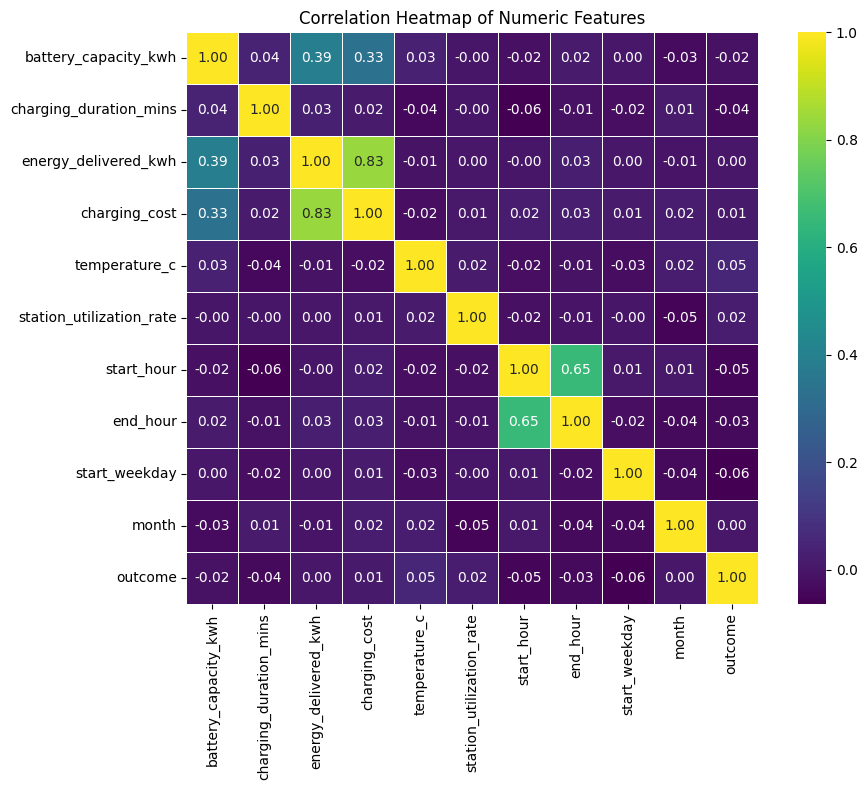

In [44]:
numeric_cols = data.select_dtypes(include='number').columns.tolist()
corr = data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            cmap='viridis',      
            annot=True, fmt=".2f",
            linewidths=0.5,
            square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.savefig("corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [45]:
corr['outcome'].sort_values(ascending = False)

outcome                     1.000000
temperature_c               0.052150
station_utilization_rate    0.020921
charging_cost               0.008688
month                       0.003877
energy_delivered_kwh        0.001724
battery_capacity_kwh       -0.016458
end_hour                   -0.034546
charging_duration_mins     -0.035793
start_hour                 -0.046131
start_weekday              -0.061531
Name: outcome, dtype: float64

Checking Outcomes Proportionality

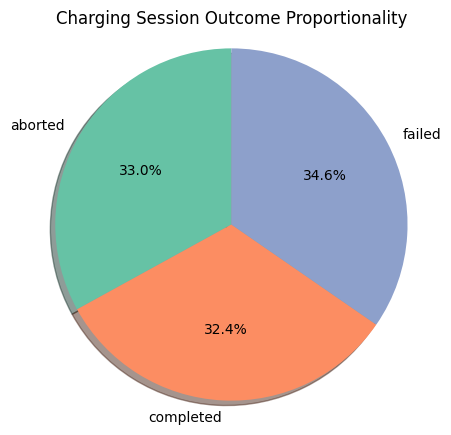

In [46]:
inv_map = {v: k for k, v in mapping.items()}
counts = data['outcome'].value_counts().sort_index()
labels = [ inv_map[i] for i in counts.index ]

plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, autopct='%.1f%%', shadow=True, startangle=90,colors=sns.color_palette('Set2'))
plt.title('Charging Session Outcome Proportionality')
plt.axis('equal')
plt.savefig("Charging Session Outcome Proportionality.png", dpi=300, bbox_inches="tight")
plt.show()

## Section 3: Model

Separate independent features and target variable

In [47]:
numeric_cols = data.select_dtypes(include='number').columns.tolist()
categorical_cols = data.select_dtypes(exclude="number").columns.tolist()

print("Numeric columns :", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns : ['battery_capacity_kwh', 'charging_duration_mins', 'energy_delivered_kwh', 'charging_cost', 'temperature_c', 'station_utilization_rate', 'start_hour', 'end_hour', 'start_weekday', 'month', 'outcome']
Categorical columns: ['country', 'city', 'charging_station_id', 'charging_station_type', 'ev_model', 'manufacturer', 'charging_start_time', 'charging_end_time', 'payment_method', 'charging_session_outcome']


In [48]:
num_cols = ['battery_capacity_kwh', 'charging_duration_mins','energy_delivered_kwh', 'charging_cost','temperature_c', 'station_utilization_rate',
            'start_hour', 'end_hour', 'start_weekday', 'month']
cat_cols = ['city', 'charging_station_type', 'ev_model']

X = data[num_cols+cat_cols]  
Y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((640, 13), (160, 13), (640,), (160,))

### Encoding/ Scaling

Some preprocessing steps involve transforming the data into a more suitable and understandable format for the algorithms. In this case, One-hot encoding will be used for the categorical variables, and label encoding will be applied for the target variable, along with normalisation (MinMaxScaler or StandardScaler) of the numeric variables.

In [49]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Create DataFrames from scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=num_cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=num_cols)

# One-Hot Encode Categorical Features
X_train_categorical = pd.get_dummies(X_train[cat_cols], columns=cat_cols, dtype=int)
X_test_categorical = pd.get_dummies(X_test[cat_cols], columns=cat_cols, dtype=int)

# Concatenate numerical and categorical features
X_train = pd.concat([X_train_scaled_df, X_train_categorical], axis=1)
X_test = pd.concat([X_test_scaled_df, X_test_categorical], axis=1)

# Convert all column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

Cross-validation Accuracy: 0.3141 ± 0.0478
Accuracy: 0.4125
              precision    recall  f1-score   support

           0       0.51      0.34      0.41        58
           1       0.43      0.53      0.48        49
           2       0.33      0.38      0.35        53

    accuracy                           0.41       160
   macro avg       0.42      0.42      0.41       160
weighted avg       0.43      0.41      0.41       160



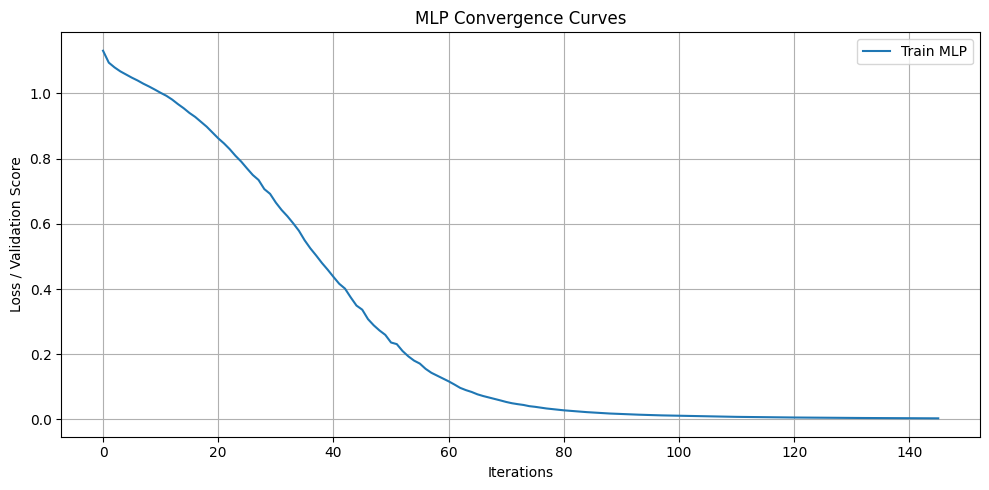

Number of layers: 4
Layer 0 -> 1 weight matrix shape: (53, 120)
Layer 1 -> 2 weight matrix shape: (120, 90)
Layer 2 -> 3 weight matrix shape: (90, 40)
Layer 3 -> 4 weight matrix shape: (40, 3)


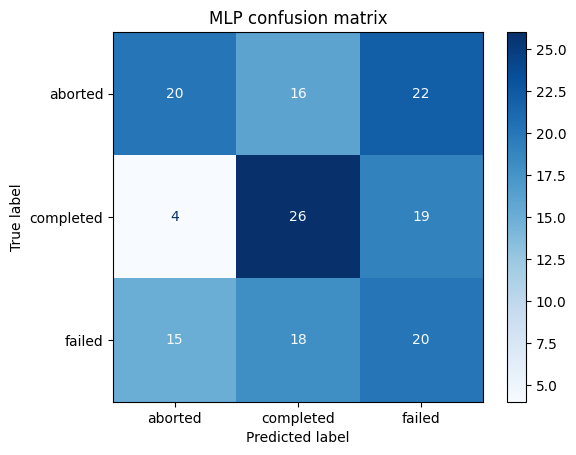

In [50]:
mlp = MLPClassifier(hidden_layer_sizes=(120, 90, 40),
                     activation='relu', solver='adam', 
                     learning_rate_init=0.001, random_state=42, max_iter=300)

mlp_scores = cross_val_score(mlp, X_train, y_train, cv=5); 
print(f"Cross-validation Accuracy: {mlp_scores.mean():.4f} ± {mlp_scores.std():.4f}")
mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(10, 5))
for model, label in zip([mlp], ['MLP']):
    if hasattr(model, 'loss_curve_'):
        plt.plot(model.loss_curve_, label=f'Train {label}')
    if hasattr(model, 'validation_scores_') and isinstance(model.validation_scores_, list) and len(model.validation_scores_) > 0:
        plt.plot(model.validation_scores_, linestyle='--', label=f'Validation {label}')


plt.xlabel('Iterations')
plt.ylabel('Loss / Validation Score')
plt.title('MLP Convergence Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Number of layers:", len(mlp.coefs_))
for i, w in enumerate(mlp.coefs_):
    print(f"Layer {i} -> {i+1} weight matrix shape: {w.shape}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("MLP confusion matrix")
plt.show()